<a href="https://www.nvidia.com/en-us/deep-learning-ai/education/"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

## Training a Semantic Segmentation Network Ready for Deployment in the Car

Lab created by Oliver Knieps

---
Before we begin, let's verify [WebSockets](http://en.wikipedia.org/wiki/WebSocket) are working on your system.  To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Ctrl-Enter, or pressing the play button in the toolbar above.  If all goes well, you should see some output returned below the grey cell.  If not, please consult the [Self-paced Lab Troubleshooting FAQ](https://developer.nvidia.com/self-paced-labs-faq#Troubleshooting) to debug the issue.

**NOTE: It is highly recommended to use Google Chrome as the web browser to run this lab.**

In [1]:
print("The answer should be three: " + str(1+2))

The answer should be three: 3


Let's execute the cell below to display information about the GPUs running on the server.

In [2]:
!nvidia-smi

Sat Feb  2 23:05:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 387.34                 Driver Version: 387.34                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   48C    P0    60W / 149W |     84MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Introduction

Real-time scene understanding based upon camera images is a major part in nowadays’ perception modules for mobile robotics and self-driving cars. In the DNN domain, this can be solved by Fully Convolutional Networks (FCNs) that perform semantic segmentation in a single forward-pass [(Long et al., 2015)](#source_fcn). As the name suggests, a semantic segmentation FCN assigns each pixel of the input image to one of the predefined classes such as "road" or "sky": This output from the perception stage can effectively be fed into localization and path-planning modules. 

To give you a first impression of the task environment within this lab, look at the following frame and its pixel-wise, hand-labeled annotation from the Cityscapes dataset [(Cordts et al., 2016)](#source_cityscapes), a poplular Semantic Segmentation dataset that we will be using (this frame has been captured in Cologne, and you actually see the Cologne Cathedral on the horizon). For now, just think of every color in the image to the right as a different class (you may be able to guess the color-to-class mapping):

<table><tr><td><img src='images/frame_0.png' width="480"></td><td><img src='images/label_0.png' width="480"></td></tr></table>
This lab takes a classification network as a baseline and shows how to turn it into an FCN architecture that will be trained on a down-scaled subset of Cityscapes for several epochs. 

A Neural Network such as an FCN is nothing else than a long series of computations depending on each other from layer to layer – knowing a network's topology allows us to estimate how many operations are needed to perform one or more predictions. This information is very useful to meet practical requirements, given by e.g. the embedded platform we develop for, how many images we need to process in a specific use case, and/or what minimum detection performance is needed. In this lab, the target hardware will be DRIVE PX 2, and you will work on meeting the set of requirements for <b>Task 1</b> as outlined in the table below.  The other two task configurations are optional thought exercises.

<a id='scenarios'></a>

|Task number |Scenario|Number of classes|Number of cameras|Frame rate for processing|Required accuracy|Computational budget on platform|
|-----|-----|-----|-----|-----|-----|-----|
|1)|Parking scenario|7 classes: Sky, Infrastructure, Road, Sidewalk, Vehicles, Vulnerable Road Users, Void | 4 cameras| Medium frame rate: 15 fps | Medium accuracy|Low budget on platform (70 Giga operations per second)|
|2)| Urban scenario|7 classes: Sky, Infrastructure, Road, Sidewalk, Vehicles, Vulnerable Road Users, Void | 4 cameras| High frame rate: 30 fps | Medium accuracy| High budget on platform (300 Giga operations per second |
|3)| Rural scenario|2 classes: Road, Not Road | 1 camera | High frame rate: 30 fps | High accuracy | Medium budget on platform (120 Giga operations per second) |
*Note: 1 Giga operation = $10^9$ operations. You will get an introduction on how we define "accuracy" in a Semantic Segmentation context later in this lab.*

We will learn how to design DNNs for Semantic Segmentation with moderate accuracies on Cityscapes, and then develop an understanding of the available budget for deployment on the target platform.
___

# 2. Approach

With this lab, we intend to shed light into creating a suitable FCN for a real-life Semantic Segmentation use case. To that end, we will modify an existing CNN architecture, MobileNets [(Howard et al., 2017)](#source_mobilenets), to perform pixel-wise classification in TensorFlow. We will familiarize ourselves with a down-scaled and simplified version of the Cityscapes dataset, which has a fully labeled training, validation and test set at an original color image resolution of 2048 by 1024 pixels. *Note that we will stick to the TensorFlow convention for dimensionality order of [height x width x channels], so that our original dataset's image size is [1024 x 2048 x 3].* In a "real" automotive scenario for Semantic Segmentation, images ingested into a DNN architecture are typically much larger than the one used in our toy example in order to have a better granularity of the predictions. This granularity is especially relevant when segmenting areas that are very distant from the camera. A small image size helps you speed up the CNN training process, so that you can spend more time on the important content of this lab.<br><br>


<font color='blue'>**Important note about chapters marked blue:**<br>This is a lab at 'Advanced' level and presents many topics at a high level of detail, especially in the "Theory and MobileNets" chapters. Not all of this information is required to complete this lab; if some contents are totally new to you and you feel that you are stuck, don't skip but just skim through the corresponding chapters marked blue. There will be some time to re-read them during the training stage for your network. The same applies to blue exercises.</font>

* [3. Theory](#chapter_theory): The next chapter covers the theoretical background needed for building a Fully Convolutional Network fitting into a previously known computational budget. The content of this chapter is targeted on a more proficient understanding and includes some questions. It first shows how to calculate the computational costs of a CNN in [3.1 Counting operations in a CNN](#subchapter_ops) (<font color='blue'>blue</font>), then introduces [3.2 Fully Convolutional Networks for Semantic Segmentation](#fcn_intro) (<font color='blue'>partially blue</font>) and eventually presents two metrics for assessing an FCN architecture's quality in [3.3 Measuring performance: Pixel-wise accuracy vs. Intersection over Union](#subchapter_perf) (<font color='blue'>partially blue</font>). 
* [4. MobileNets: An adjustable CNN as the fully convolutional stem](#chapter_mobilenets): You would rarely start from scratch when designing a Convolutional Neural Net for a specific purpose, and rather re-use successful architectures from academia and research. During this lab, we will make use of a subsets of the MobileNets topology. MobileNets, whose base version is designed for classification tasks, are interesting to us because they are generally not too resource-hungry and also give us a convenient parameter for scaling our computational needs – to the expense of a potentially lower performance. We will get to know MobileNets in general in [4.1 MobileNets basics](#subchapter_mobilenets_basics) (<font color='blue'>partially blue</font>), and then identify the subset which we can re-use for an FCN architecture in 
[4.2 Preparing MobileNets for a Semantic Segmentation task](#subchapter_mobilenets_prepare).
* [5. Attaching a simple FCN head for Semantic Segmentation](#chapter_fcn_head): Having derived a subset of scalable MobileNets as our FCN "stem" and also having the background on FCN architectures from the Theory chapter, all we need to do now is to connect those dots. During the fifth chapter, we will turn FCN theory into practice and attach a simple FCN "head" to the MobileNets stem which allows us to train the resulting overall topology on a Semantic Segmentation task.
* [6. Preparing the dataset and importing it into DIGITS](#chapter_dataset): We will train the FCN architecture generated in the preceding chapter in DIGITS, using its TensorFlow back-end. Before that, we will have to modify a down-sampled version of the Cityscapes dataset – reducing its labels to the number of classes given in your scenario – and then import it into DIGITS.
* [7. Putting everything together: Training in DIGITS](#chapter_fcn_training): This is the final part of the lab where all the previously introduced parts come together. Having in mind [the specific use case you have been assigned to](#scenarios), you will first explore which MobileNets can potentially meet your scenario's budget constraints, attach an FCN head and train it on the previously modified Cityscapes dataset. Since we are collecting performance numbers from other participants at the end of this lab, you will get a feeling for the trade-off between resource consumption and performance in a CNN setting.
___

<a id='chapter_theory'></a>
# 3. Theory
<a id='subchapter_ops'></a>
## <font color='blue'> 3.1 Counting operations in a CNN </font>
State-of-the-art Convolutional Neural Networks require millions and billions of operations for a single prediction (even more for the back-propagation step during training). Since CNNs are that resource hungry and at the same time of paramount importance to nowadays' AI applications, they have become one of the favorite benchmarks for measuring a hardware's performance.

The costliest as well as most frequent operation of CNNs – consuming easily more than 95% of the total computation time – is contained in their convolution layers (we will refer to this as "Classical Convolution", because you will get to know a less hungry convolution variant later). Let's understand how many operations Classical Convolution requires with the help of a simple example. It is not too important that you understand every detail of it, but it is key that you understand from which inputs the formula at the bottom of this paragraph can be derived:

Consider you want to process an input color image with one red, one green and one blue channel ($c_i = 3$) at a height of $h_i = 4$ pixels and a width of $w_i = 8$ pixels through a Classical Convolution layer (without adding the bias term). The convolution shall use $n_f = 6$ square filters with a height of $h_f=5$ pixels and a width of $w_f=5$ pixels. We also do not want to skip any input pixel and set the stride to $s=1$. To facilitate the calculation a bit, let's assume that we will zero-pad our input image with $(5-1)/2 = 2$ pixels on all its borders, so that our output image has the same spatial dimensions as our input image: $h_o = h_i = 4$ and $w_o = w_i = 8$ (with a stride of 2, we would skip every other pixel and have a spatial output dimensionality of 2 by 4 pixels). Since each filter will create one output feature map of the previously mentioned spatial dimensions, we also know the output depth: $d_o = n_f = 6$. Here is a brief sketch of the input feature maps, one of the 6 filters/kernels, and the output feature maps:

<img src='images/CNN_example.png'>

That means every pixel, for example, the one marked with an 'X', of the 3-dimensional output volume with size ($h_o$ x $w_o$ x $d_o$) = ($4$ x $8$ x $6$) is the result of one convolution operation. Such operation is nothing else than multiplying $h_f * w_f * d_i = 5 * 5 * 3 = 75$ input pixels with the $h_f * w_f$ filter weights and accumulating them to a single value: That means it takes $h_f * w_f * d_i = 75$ multiplications and $h_f * w_f * d_i = 75$ additions, which yields $2 * h_f * w_f * d_i = 150$ operations per convolution. On a modern GPU, this can be performed especially efficiently because it can typically calculate one multiply-accumulate (MAC) operation per CUDA core (of which you have hundreds on the NVIDIA Pascal architecture) for float32 values ("single precision") in one cycle – sometimes even 2 or 4 when processing float16 ("half precision") or int8 values. The number of physical MAC units on a GPU available for operations at the target precision – determining how many MAC operations you can process per cycle – together with its clock frequency hence define its theoretical ability or budget to run CNN inference. As an embedded developer, you will often come to a situation where the budget for your application is just a fraction of the maximum budget. This is exactly what you see in the [use case you are working on!](#scenarios).

To capture everything in one formula, it takes
<a id='n_mac'></a>$$MAC^{classical} = h_o * w_o * n_f * h_f * w_f * c_i $$
multiply-accumulates or
$$ops^{classical} = 2 * MAC^{classical} = 2 * h_o * w_o * n_f * h_f * w_f * c_i $$

operations per Classical Convolution layer, $h_o$ and $w_o$ being the output height and width of the layer, respectively, $n_f$ being the number of filters with a kernel height of $h_f$ and a kernel width of $w_f$, and $c_i$ being the number of input channels.
<a id='q_3_1_1'></a>
___
### <font color='blue'>Question 3.1.1</font>
How many operations does it take to compute above example using Classical Convolution?
___
Given the formula above, together with formulae to obtain the number of operations for less complex layer types, we can easily calculate the computational costs of popular CNN architectures. One common key performance indicator of nowadays' classification CNNs is the highest Top-1 accuracy achieved on the ImageNet [(Deng et al., 2009)](#source_imagenet) classification test dataset (next to the Top-5 accuracy). Plotting a neural network's computational needs for one prediction on the horizontal axis in Giga operations (note the logarithmic scale) and the Top-1 accuracy on the vertical axis, we see that high performing network topologies come with high costs; **the bubble size of each entry in the graph indicates how many parameters can be learned, which means that it shows a model's capacity**:
<a id='cnn_graph'></a>
<img src='images/CNN_gops.png'>
*The Top-1 accuracies are based on data from https://github.com/tensorflow/models/tree/master/research/slim#pre-trained-models and https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet_v1.md. The number of operations per prediction has been measured with TensorFlow implementations from https://github.com/tensorflow/models/tree/master/research/slim/nets.*

It also becomes obvious that popular architectures such as AlexNet by [Krizhevsky et al. (2012)](#source_alexnet), (shown here is the a modified version accepting images of 224 by 224 pixels), GoogLeNet [(Szegedy et al., 2015)](#source_googlenet) and VGG-16 [(Simonyan and Zisserman, 2014)](#source_vgg) are not necessarily the best choice if your compute resources are constrained. In this lab, we will make use of the MobileNet architecture [(Howard et al., 2017)](#source_mobilenets) represented by the four leftmost data points. While one prediction with any of the four MobileNet versions requires fewer operations than when using AlexNet or GoogLeNet, the best performing MobileNet (MobileNet-1.0) also outperforms both of the latter in terms of Top-1 accuracy.
<a id='q_3_1_2'></a>
___
### <font color='blue'>Question 3.1.2</font>
Even though VGG-16 appears to be inferior to other topologies in terms of Top-1 classification accuracy and requires the most computations, what could be an argument of still using it? *Answer this question based only upon the graph.*

___
<a id='fcn_intro'></a>
## 3.2 Fully Convolutional Networks for Semantic Segmentation

Before introducing Fully Convolutional Networks, let's reiterate what we know about "traditional" CNN architectures used for compressing *all pixels* from the input image into *one vector* with as many one-dimensional elements as pre-defined classes, which allows us to determine a class belonging to the value with the highest score. Through a cascade of layers (e.g. convolution, activation, normalization, and pooling), spatial information from the input image is usually preserved until the first layer drastically reducing the spatial dimensionality of its input (for which the input has to be "squeezed"). This may be achieved through average pooling layers with large sliding windows for instance, or, occurring in nearly all popular classification CNNs, through one or more fully connected layers towards the end of the network topology.

### 3.2.1. First observation: The task of classification kills spatial context at a certain point
For AlexNet [(Krizhevsky et al., 2012)](#source_alexnet), the need for squeezing becomes obvious when looking at e.g. the MXNet visualization of its topology: In many Deep Learning frameworks, a fully connected layer can only take a vector as an input. For that reason, we first have to vectorize the output of the blue pooling layer `pool5` by feeding it through the orange `flatten0` layer, which is then connected to the fully connected layer`fc6`:
<img src='images/AlexNet_head.png'>
From a spatially ordered representation of $256$ feature maps of $6$ by $6$ pixels, we switch to an unordered representation of $256 * 6 * 6 = 9,216$ values. The following fully connected layer has exactly $9,216 * 4,096$ learnable weights (without the bias) and, unlike convolution layers, expects an input vector of exactly $9,216$ elements. That is also why we cannot easily modify the input size to a given classification topology. If we used a slightly larger input image for AlexNet that would result in an output of $256$ x $7$ x $7$ after the blue Pooling layer `pool5`, the output of the `Flatten` layer would be a $12,544$-element vector – which wouldn't fit the shape of the subsequent fully connected layer if it was trained with $9,216$ inputs.

### 3.2.2 Second observation: Classification CNNs also "classify" pixel-wise

Even for an off-the-shelf classification CNN pre-trained on e.g. the ImageNet [(Deng et al., 2009)](#source_imagenet) dataset, you will see that the feature maps created by convolutional layers just before being "squeezed" show interesting behavior if we use the left-hand side image from the Introduction as an input. To elaborate on this, we have fed that frame into an ImageNet pre-trained AlexNet and visualized its layer's activation in DIGITS.

First of all, note that the images from the Cityscapes dataset all have non-squared dimensions, while AlexNet (the popular first version that won the ILSVRC-2012 competition) accepts color images of 227 by 227 pixels. Corresponding to a widely used convention, we fitted the original input into square dimensions and scaled it to AlexNet's expected input dimensions (also called "squashing") in the `data` layer:
<img src='images/AlexNet_data.png'>
Let's now jump to the feature maps produced by the network's last convolution layer (after ReLU activations), Layer `conv5`. 
<img src='images/AlexNet_conv5_box.png'>
There we magnify one particular activation map marked green (second row, third column) from 13 by 13 pixels and overlay the squashed input image with it – low activations are shown in dark blue, medium activations in green, and high activations in red:
<table><tr><td><img src='images/squashed.png' width="227"></td><td><img src='images/overlay.png' width="227"></td><td><img src='images/fill.png' width="227"></td></tr></table>

It looks like this highlighted feature map shows high activations in corresponding areas where the closest car is present (which wouldn't be too surprising, since the ImageNet dataset this AlexNet was trained with contains several car classes: http://image-net.org/search?q=car). Of course, this claim sounds a bit hand-wavy at this point since AlexNet had been trained for a different task, but think of this principle as a major motivation for Fully Convolutional Networks. This will be covered in the next section.

<a id='fcn_details'></a>
### 3.2.3 From one single prediction to several spatially ordered predictions through Fully Convolutional Networks 

In the example earlier, we found an interesting spatial relationship between the input image and one activation map after AlexNet's last convolution layer `conv5`. In fact, we could find that many neurons in the 256 feature maps created by that convolution layer "fire" in regions that may be of interest to Semantic Segmentation of our input image. What if we could replace the fully connected layers (for which we need to flatten spatially ordered feature maps) by one or several layers that classify pixel-wise and preserve locality? 

[As we remember](#fcn_intro), classification into $n$ classes through a CNN signifies creating one vector with $n$ elements per input to be classified. We have also learned that Semantic Segmentation actually means assigning one of $n$ classes to each pixel of an input image with the resolution $h_i$ x $w_i$. When using a CNN for a Semantic Segmentation task, the expected output of the topology should hence be a volume of the size $h_i$ x $w_i$ x $n$. We can achieve this by **convolutionizing** a CNN topology: Instead of using layers that destroy spatial context, we build in convolution layers, so that the CNN outputs a volume with a dimensionality of $h_i$ x $w_i$ x $n$. According to [Long et al. (2015)](#source_fcn), we will call such an architecture a **Fully Convolutional Network**.
___
*Fully Convolutional Networks put into context with the State of the Art*

In practice, Fully Convolutional Networks often include so-called skip connections from feature maps of different resolution that are all upsampled to the target output size with separate Transposed Convolution layers, and eventually fused to a single output.

Note, FCNs are not the only approach to solving Semantic Segmentation tasks through DNNs. For example, a pre-trained model of U-Net [(Ronneberger et al., 2015)](#source_unet) will be available in the [DIGITS 6 Model Store](#https://developer.nvidia.com/digits) soon. U-Net is a topology that first decreases the spatial input size with an “encoder” of Classical Convolution layers and then increases the resolution again to the input resolution, using a symmetrical “decoder” of Transposed Convolution layers.

___
*1x1 convolutions as pixel-wise classifiers*

A fully connected layer is used for image classification since it has the ability to take all pixels in an input feature map into account for the prediction task. If we wanted to classify pixel-wise, what would we have to adjust to that approach? To get there, think of the following example where our input feature map's resolution is just 1x1 pixel ($h_i = w_i = 1$) with $c_i$ input channels, and we want to classify this huge "column" into $n$ classes in one layer.

With a fully connected layer, each of the $c_i$ pixel slices would have a connection to each of the $n$ elements in the output vector; we would thus have $c_i * n$ learnable weights for these connections. 

Let's see what would happen if we used a Convolution layer with $n$ filters instead! Naturally, we would choose a filter height and width of 1 – a filter larger than the spatial input dimensions would not make much sense: $h_f = w_f = 1$. Since we are using $n$ filters, we would correspondingly create a volume at the same spatial dimensions as the input (1x1) and at a depth of $n$, i.e., another one-pixel column at the depth of $n$. Hence both input and output dimensions for the fully connected layer and the 1x1 (point-wise) convolution layer are the same; but what about the internal computations, are they also equivalent?

Let's look at one of the $n$ output pixels generated from the 1x1 convolution layer: It is calculated from a point-wise multiplication of the weights from one of the filters with the input column of the same dimensionality, and  both the filter and the input have a dimensionality of [$1$ x $1$ x $c_i$]. This is nothing else than having $c_i$ direct connections with learnable weights from all input pixels to the output pixel in focus.  Now, knowing that there are $n$ output pixels, let's also connect our dots and derive the total number of learnable weights from such a 1x1 convolution layer – it is again $c_i * n$, just like in a fully connected layer, but we have the extremely beneficial property that we can use a convolutional layer flexibly with different spatial input sizes.

Achieving an output volume of width and depth of $n$ filter maps seems to be relatively easy to achieve through a Classical Convolution layer: We can set the number of filters $n_f$ to $n$ and will end up with $n$ output feature maps – one for each class. The next section will show how a resolution of the input image, $h_i$ x $w_i$, can be met.

This [video explanation](https://www.youtube.com/watch?v=9EZVpLTPGz8) by Andrew Ng can help further understand 1x1 convolutions. 
___
<a id='transposed_conv'></a>
*Transposed Convolution*

Throughout this tutorial, we have only referred to convolution operations that either maintain the spatial input dimensions for the output feature maps (if the stride is $s=1$, and we have a "full" padding with $p=(f-1)/2$) or produce feature maps that have a lower resolution (e.g. for a stride $s>1$). So there is one question that remains: How can we "upsample" a highly condensed feature map with a resolution of just a few pixels to an original input resolution of e.g. 224 by 224 pixels? The answer is a layer type that you may have also heard of as "Deconvolution": Transposed Convolution. While the **Classical Convolution moves a filter window over an input volume** and calculates an output from a weighted sum of the pixels in that window, **Transposed Convolution moves a filter window over an output volume** that is initialized with zeros. It only takes a single input pixel, multiplies it with all filter weights, and adds the result to the corresponding elements in the output volume. It is also important to note that zero-padding for Transposed Convolution means adding additional pixels to the output feature map. 

Here a simple example taken from [the official Theano documentation](http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html#no-zero-padding-unit-strides-transposed):
<img src='images/no_padding_no_strides.gif'>
In above animation, we have an input of 2 x 2 pixels ($i = 2$) with just a single channel, and a Transposed Convolution kernel of 3 x 3 pixels ($k = 3$) – without any zero-padding so that $p=0$, and with a stride of $s=1$. Then we can calculate the output size with edge length $o$:

$$o = s(i-1) + k - 2p$$

Which, for the former example, would be $o = 1*(2-1)+3-2*0 = 4$. 

For Transposed Convolution, think of the sliding window as a brush tool as you know it from your favorite raster graphics editor such as GIMP: <br>
In this virtual setting, our mouse pointer would determine the position of the input pixel. While you could control the size of the area that you "paint" color on through adjusting the kernel size $k$, the stride parameter $s$ would define the continuity of your brush strokes if you move your mouse pointer over the screen with the mouse button pressed. Within this analogy, the kernel weights would be a learnable shape and intensity of your brush area.

*<font color='blue'>Calculating the parameters for Transposed Convolution</font>*

To show you how to use this formula in practice, let's see how you would set the parameters to upscale an input size $i$, which may be the height or width, by a factor of $x$, so that $o = xi$:

First of all, we would like to make sure that all our Transposed Convolution operations – or "brush strokes" – are overlapping. If we set the stride parameter $s$ to the same value as the kernel size $k$, we would not be able to achieve this because all window positions would be perfectly adjacent. However, if we choose the stride to be exactly half the kernel size so that $k = 2s$, we will always have an overlap of half a brush stroke between striding window positions. This sounds like a good setup, so let's keep this condition. 

Now we will apply a short-hand trick to achieve an output of $o = xi$ where we set $s=x$, $k=2s=2x$ and $p=s/2=x/2$ (if you are interested, you can look at how this setting has been derived after the lab):

$$o = s(i-1) + k - 2p = x(i-1) + 2*x - 2(x/2) = x(i-1) + 2x-x = x(i-1) +x = xi$$

In parameter space, we can thus determine a function for upscaling an input by a target factor $x$:
$$\theta(x): N_0 \rightarrow N_0^3$$ 
$$\theta(x) = (s,k,p)^T = (x,2x,x/2)^T,$$
$s$ being the stride, $k$ the kernel size, and $p$ the zero padding parameters of the Transposed Convolution layer.
<a id='transposed_question'></a>
___
### <font color='blue'>Question 3.2.3</font>
Using above formula $\theta(x)$, how would you set the parameters for stride $s$, kernel size $k$ and zero-padding $p$ if you wanted to upscale an image by the factor $x=32$?

<a id='subchapter_perf'></a>
___

## Answers to Questions 3.1.1 - 3.2.3

3.1.1) How many operations does it take to compute the above example using Classical Convolution? 

####  See code below

3.1.2) Even though VGG-16 appears to be inferior to other topologies in terms of Top-1 classification accuracy and requires the most computations, what could be an argument of still using it? Answer this question based only upon the graph.

####  VGG-16 may still be favorable because of the large amounts of parameters, in other words, the model's capacity, it has the possibility of learning, relative to the other networks. 

3.2.3) Using above formula, how would you set the parameters for stride _s_, kernel size _k_ and zero-padding _p_ if you wanted to upscale an image by the factor  x = 32 ?

#### theta(x) = (s,k,p).T = (32, 64, 16).T

In [2]:
ci = 3
ho = 4
wo = 8
hf = 5
wf = 5
nf = 6

def calcClassical(ho,wo,nf,hf,wf,ci):
    MAC_classical = ho*wo*nf*hf*wf*ci 
    return 2*MAC_classical

ops_classical = calcClassical(ho,wo,nf,hf,wf,ci)

print('It would take {0} operations'.format(ops_classical))

It would take 28800 operations


## 3.3 Measuring performance: Pixel-wise accuracy vs. Intersection over Union


### 3.3.1 Pixel-wise accuracy
When classifying pixel-wise, you could treat each pixel prediction similarly to how you would for a "traditional" classification task. This would mean, if we had an image row of 1 x 4 pixels with the three leftmost pixels labeled as Class A and the rightmost pixel labeled as Class B, a single wrong prediction of the rightmost pixel would result in an accuracy of $3/4 = 75\%$. 

<img src='images/accuracy_example.png' width="320">

In other words, if we predicted all 4 of the pixels to be class A, we would still achieve a relatively good accuracy of $75\%$! Class imbalances are very common in Semantic Segmentation annotations: Think of an urban dataset taken from forward-looking camera mounted on a car where a huge portion of the pixels in *every* frame would be labeled as 'Sky', and comparably few pixels would be labeled as 'Pedestrian' in only those frames where pedestrians are visible. This is equivalent to our class A and class B example.




We hence need a stricter metric which is often preferred in a Semantic Segmentation task: Intersection over Union, which is used in the popular Pascal VOC Challenge ([(Everingham et al., 2010)](#source_iou), for instance.

### <font color='blue'>3.3.2  Intersection over Union</font>

While we can calculate the pixel-wise accuracy directly through comparison of the expected output (the label) and the predicted output of a pixel-wise classifier, Intersection over Union is first calculated for all classes separately, and then averaged over all classes for achieving the overall Intersection over Union score. This allows for a balanced analysis of all present classes; in practice, knowing that some classes are more relevant to the particular use case than others, weighted averages are also often used. In this lab, we will consider all classes as equally important, and just use the arithmetic mean over $N$ classes:

$$IoU_{total} = \frac{\sum_{i=1}^{N}IoU^{class}_i}{N}$$

Let's now explore how to calculate the class-wise Intersection over Union score $IoU^{class}:$
Looking at prediction results for each class separately turns the problem into a binary classification with True Positives ($TP$), False Negatives($FN$), False Positives ($FP$) and True Negatives ($TN$). In case you do not remember how to determine these outcomes, we have listed them here for the class in focus:

|Label|Prediction|Outcome|
|-----|-----|-----|
|Class in focus ($True$)|Class in focus($True$)|True Positive ($TP$)|
|Class in focus ($True$)|Different class ($False$)|False Negative ($FN$)|
|Different class ($False$)|Class in focus ($True$)|False Positive ($FP$)|
|Different class ($False$)|Different class ($False$)|True Negative ($TN$)|

For the class-wise Intersection over Union score $IoU^{class}$, we will not take into account any True Negatives ($TN$) – a value that is only dependent on predictions and labels for different classes than the one in focus:

$$IoU^{class} = \frac{\sum{TP}}{\sum{FN}+\sum{FP}+\sum{TP}}$$


To extend our initial example with a 4-pixel image, we have calculated the class-wise IoU scores for both Class A and Class B below, and also the overall IoU metric (using the arithmetic mean). Those pixels that are used by the IoU formula are marked with a blue box:
<img src='images/IoU_example.png' width="800">
As you see, a pixel-wise classifier only predicting Class A can more easily be interpreted as futile based upon the IoU score. We will accordingly use Intersection over Union as the key accuracy performance indicator during this lab, which is also the most common metric used for Semantic Segmentation competitions.

### 3.3.3 Loss

For the loss calculation, we will use an approach that is probably the most common for all kinds of classification DNNs: Cross Entropy Loss applied to class-wise probabilities for each pixel after using a Softmax operation. There are other NVIDIA Deep Learning Institute labs that pay special attention to different kinds of loss calculation for Semantic Segmentation, for example `Image Segmentation with TensorFlow`.

<a id='chapter_mobilenets'></a>
# 4. MobileNets: An adjustable CNN as the fully convolutional stem

Within the concept of Fully Convolutional Networks, we will use MobileNets [(Howard et al., 2017)](#source_mobilenets) as the encoder responsible for distilling a "raw" input image into a much lower resolution one, containing hundreds of learned features per pixel. 

<a id='subchapter_mobilenets_basics'></a>
## 4.1 MobileNets basics

Often design choices in the embedded domain are driven by computational requirements, [just like your target use case](#scenarios) – with MobileNets (notice the plural form: it is rather a set of networks than a single DNN), we are given a scalable concept for designing convolutional networks at different levels of fidelity, depending on the requirements of the task at hand.

## <font color='blue'>4.1.1 Depth-wise Convolutions</font>
Before looking at MobileNets' scalable nature, let's spend some time on understanding another key concept they make use of to keep the workload low and still achieve considerably good results: **Depth-wise Convolutions** [(Chollet, 2016)](#source_depthwise). Unlike the "classical" convolutions used in popular network topologies such as VGG [(Simonyan and Zisserman, 2014)](#source_vgg), GoogLeNet [(Szegedy et al., 2015)](#source_googlenet) or ResNet [(He et al., 2016)](#source_resnet), a single kernel from a Separable Convolution layer (e.g. at a size of $3$x$3$ pixels) convolves over all input feature maps separately in a first step – instead of convolving at the full depth of all input feature maps. This first step, also called Separable Convolutions, will always produce the same number of output feature maps as input feature maps and does not "mix" them; Separable Convolutions involve $MAC^{SC}$ multiply-accumulates:

$$MAC^{SC} = h_o * w_o * c_i * h_f * w_f$$

To overcome the deficiencies of not being able to choose the number of output feature maps and having no option for channel mixing, Separable Convolutions are followed by so-called Point-wise Convolutions (there are actually batch normalization and ReLU activation layers attached to them, but this does not affect the number of operations too much). This second step of Depth-wise Convolutions is simply a convolution layer with a spatial kernel size of 1x1 pixel, convolving over all "stacked" output feature maps of the Separable Convolution step. We can thus use the [the formula for calculating multiply-accumulates of Classical Convolution](#n_mac) from earlier, setting the kernel height and size to 1 so that our output resolution stays at $h_o$ x $w_o$, and keeping $c_i$ from the calculation of $MAC^{SC}$:

$$MAC^{PW} = h_o * w_o * c_i * n_f * 1 * 1 = h_o * w_o * c_i * n_f$$


Hence Depth-wise Convolutions require the following number of multiply-accumulates and operations:

$$MAC^{DW} = MAC^{SC} + MAC^{PW} $$

$$MAC^{DW} = h_o * w_o * c_i * h_f * w_f + h_o * w_o * c_i * n_f $$

$$MAC^{DW} = h_o * w_o * c_i * (h_f * w_f + n_f) $$

$$ops^{DW} = 2 * MAC^{DW} = 2 * h_o * w_o * c_i * (h_f * w_f + n_f) $$

That means our reduction factor $r$ of operations for using Depth-wise Convolutions instead of Classical Convolution is:

$$r_{ops} = \frac{2 * h_o * w_o * c_i * h_f * w_f * n_f }{2 * h_o * w_o * c_i * (h_f * w_f + n_f)} = \frac{h_f * w_f *n_f}{h_f * w_f + n_f}$$
<a id='q_4_1_1'></a>
___
### <font color='blue'>Question 4.1.1</font>
Let's consider the following:

We have an input layer with [$h_i$ x $w_i$ x $c_i$] = [4 x 4 x 5] <br>
We will use $n_f=8$ kernels with [$h_f$ x $w_f$ x $c_f$] = [3 x 3 x 5], and a padding of $p=1$ (`'SAME'` output resolution as input resolution) <br>

What is the shape of the expected output assuming Classical Convolution?
What is the reduction factor $r_{ops}$ of using Depth-wise Convolutions instead of Classical Convolution?
___

## 4.1.2 Depth Multiplier in MobileNets
Using Separable Convolutions reduces the overall number of multiply accumulates for MobileNets, which helps to achieve an ImageNet top-1 classification accuracy slightly better than GoogLeNet at less than 40% of the floating-point operations (for MobileNet-**1.0**, note the factor at the end). But what if we have to use larger input images for recognizing a target level of detail – and this at frame rates of e.g. 30 fps – but MobileNet-1.0 does not fit into our available resource budget? 

MobileNets have specifically been designed to answer this type of question. At the expense of an expected lower accuracy (not only for the ImageNet classification challenge), we can adjust all convolutional layers' number of computations through a single parameter: The **Depth Multiplier**, which is appended to all MobileNet instances in  [the previously shown graph](#cnn_graph). The Depth Multiplier allows to decrease or increase the number of filters per Depth-wise Convolution layer according to your requirements; taking the example from earlier again as a baseline and setting the default depth to 1024, this is how the number of multiply-accumulates scales with different Depth Multipliers:

|Depth Multiplier |MAC count of the example Depth-wise Convolution layer|
|-----|-----|
|8/1024 |4 x 4 x 5 x (3 x 3 + 8) = 1,360|
|0.25 |4 x 4 x 5 x (3 x 3 + 256) = 21,200| 
|0.5 |4 x 4 x 5 x (3 x 3 + 512) = 41,680|
|0.75 |4 x 4 x 5 x (3 x 3 + 768) = 62,160 |
|1.0 |4 x 4 x 5 x (3 x 3 + 1024) = 82,640 |
|1.25 |4 x 4 x 5 x (3 x 3 + 1280) = 103,120 |







That means, for large output depths, the number of MACs almost scales linearly with the Depth Multiplier since the filter size (here $3*3=9$) becomes negligible. Let's now use this knowledge in practice with the TensorFlow implementation of MobileNets.

## Question 4.1.1

What is the shape of the expected output assuming Classical Convolution? What is the reduction factor _rops_ of using Depth-wise Convolutions instead of Classical Convolution?

#### See code below

In [3]:
ho = 4
wo = 4
ci = 5
nf = 8
hf = 3
wf = 3
cf = 5

def calcDepthWise(ho,wo,nf,hf,wf,ci):
    MAC_DW = ho*wo*ci*(hf*wf+nf)
    return 2*MAC_DW

r_ops = calcClassical(ho,wo,nf,hf,wf,ci)/(calcDepthWise(ho,wo,nf,hf,wf,ci))

print('The shape of the expected output using classical convolution is [4x4x5]')
print('The reduction factor is equal to {0}'.format(r_ops))

The shape of the expected output using classical convolution is [4x4x5]
The reduction factor is equal to 4.235294117647059


<a id='subchapter_mobilenets_prepare'></a>
## 4.2 Preparing MobileNets for a Semantic Segmentation task

<img src="images/mobilenet_arch.png">

The above table describes MobileNet architecture as found on page 4 of the <a href="https://arxiv.org/abs/1704.04861">paper</a>: *"MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications"* (authored by Andrew G. Howard, Menglong Zhu, Bo Chen, Dmitry Kalenichenko, Weijun Wang, Tobias Weyand, Marco Andreetto, and Hartwig Adam).

The rest of MobileNet paper is optional reading material for your interests.  In the table above, we see a listing of layers and their respective input sizes in the leftmost column. What we really care about for convolutionalizing MobileNets is a layer's output size, which is unfortunately not explicitly listed: Here, an output size [$h_o$ x $w_o$ x $c_o$] at layer $n$ implies that the following layer $n+1$ has a corresponding input size. We can ignore the number of channels (the last factor in the rightmost column) for now, since we are primarily interested in the downsampling factor from layer to layer. For example, the first convolution layer "Conv / s2" ("s2" stands for a stride of two, skipping every other pixel during convolution) produces an output of half the spatial size of its input: [$112$ x $112$].

We require a specific (fully convolutional) subset of MobileNets that we can re-use for our Semantic Segmentation task in mind. Luckily, the creators provide us with a handy function for constructing custom MobileNets. During this lab, not all of the optional arguments are of importance – we occluded the less relevant and focus on the following three: 

- Of course, it is necessary to specify a tensor containing the image data in **`inputs`** so that the spatial dimensions can iteratively be adjusted from layer to layer (you can specify tensors of input sizes other than [$224$ x $224$ x $3$])

- The construction of our custom MobileNet instance will terminate at the layer with the string identifier **`final_endpoint`**. For instance, you could let your MobileNet creation stop after the first layer by filling in `'Conv2d_0'`, which is the only "classical" convolutional layer with kernel size $3$ x $3$ and a stride of $2$.

- As described earlier, the parameter **`depth_multiplier`** dictates how many filters of the specified size are learned in **all convolutional layers**, and is therefore a useful measure to adjust the computational needs and the capacity of your network topology. By default, it is set to `1.0`. In the first layer `'Conv2d_0'`, this default setting results in $32$ filter maps. Lowering `depth_multiplier` to e.g. `0.5` would reduce the number of filter maps to $16$ for `'Conv2d_0'` – reducing the layer's computational requirements as well as its capacity – and correspondingly halve all other convolution layers' number of filter maps, too.

Take a brief look at the reduced version of the function, and pay special attention to the options for `final_endpoint`:

```python
def mobilenet_v1_base(inputs,
                      final_endpoint='TheLayerYouChoose',
                      depth_multiplier=1.0)
  """Mobilenet v1.

  Constructs a Mobilenet v1 network from inputs to the given final endpoint.

  Args:
    inputs: a tensor of shape [batch_size, height, width, channels].
    final_endpoint: specifies the endpoint to construct the network up to. It
      can be one of ['Conv2d_0', 'Conv2d_1_pointwise', 'Conv2d_2_pointwise',
      'Conv2d_3_pointwise', 'Conv2d_4_pointwise', 'Conv2d_5'_pointwise,
      'Conv2d_6_pointwise', 'Conv2d_7_pointwise', 'Conv2d_8_pointwise',
      'Conv2d_9_pointwise', 'Conv2d_10_pointwise', 'Conv2d_11_pointwise',
      'Conv2d_12_pointwise', 'Conv2d_13_pointwise'].
    depth_multiplier: Float multiplier for the depth (number of channels)
      for all convolution ops. The value must be greater than zero. Typical
      usage will be to set this value in (0, 1) to reduce the number of
      parameters or computation cost of the model.

  Returns:
    tensor_out: output tensor corresponding to the final_endpoint.
    end_points: a set of activations for external use, for example summaries or
                losses.

  Raises:
    ValueError: if final_endpoint is not set to one of the predefined values,
                or depth_multiplier <= 0, or the target output_stride is not
                allowed.
  """
```



___
<a id='exercise_A'></a>

### Exercise A

As mentioned before, MobileNet's strided convolution layers are responsible for gradually reducing the spatial input sizes to the network. Look at the table on page 4 of the MobileNet paper for answering the following questions:
<a id='q_4_2_1a'></a>
___
#### Question 4.2.1
Until which layer can we consider the network topology (with an input size of [$224$ x $224$ x $3$]) as a 'fully convolutional neural network', preserving spatial information from its input image?
<a id='q_4_2_2a'></a>

#### It appears that the network maintains its 'fully connected' status until the depthwise convolution with a stride of 2 (s=2) with the 3x3x256 dw filter. 
___
#### Question 4.2.2
In the largest fully convolutional subset of MobileNet, by which factor do we "downsample" the input image's spatial dimensions? Compare the input dimensions to the network and the output dimensions of the FCN subset.
___

#### TODO

### Exercise B
Verify your assumptions from Exercise A by playing around with the following code snippet and answering the following questions:
<a id='q_4_2_3b'></a>
___
#### Question 4.2.3
If we want to encode the input image to a spatial representation at $\frac{1}{32}$ of both the input height and the input width (from an input dimensionality of [$224$ x $224$ x $3$]), which layers can we select as an end point? Similarly, which layers can we choose as an endpoint if we want to "downsample" by a factor of 16? Modify `my_endpoint`.

#### For a downsampling of 1/32, we can select the endpoint to be Conv2d_12_pointwise. For a downsampling of 1/16, we can select the endpoint to be Conv2d_11_pointwise. 

<a id='q_4_2_4b'></a>
___
#### Question 4.2.4
If you were to change the input size to e.g. [$360$ x $480$ x $3$], do we achieve the same downsampling factor for input height and the width if we set `my_endpoint` to `'Conv2d_13_pointwise'`?

#### Since the input image size is not square, the downsampling factor for height (1/30) is less than the downsampling factor width (1/32). 
___

In [3]:
import tensorflow as tf
from tensorflow.contrib import slim
from mobilenet_v1 import *

## Modify these lines for Question 4.2.4
######################################################################
height = 224 # The height of one input image
width = 224 # The width of one input image
######################################################################

# We will replace this placeholder with our training images later
my_image_tensor = tf.placeholder(tf.float32, shape=(1, height, width, 3))


######################################################################
# Choose an appropriate endpoint for creating a custom MobileNet.
# hint: Have a closer look at mobilenet_v1_base documentation above.
my_endpoint = 'Conv2d_0'
######################################################################

# To prevent multiple graphs being active during one session, we reset the default graph every time we run this snippet
tf.reset_default_graph()
my_mobilenet,my_endpoints = mobilenet_v1_base(inputs=my_image_tensor,
                  final_endpoint=my_endpoint,
                  depth_multiplier=1.0)
input_shape = my_image_tensor.get_shape().as_list()
output_shape = my_mobilenet.get_shape().as_list()
print('Input dimensions: ' + str(input_shape))
print('Output dimensions: ' + str(output_shape))
print('Height downsampling factor: %.1f' % (input_shape[1]/output_shape[1]))
print('Width downsampling factor: %.1f' % (input_shape[2]/output_shape[2]))

Input dimensions: [1, 224, 224, 3]
Output dimensions: [1, 112, 112, 32]
Height downsampling factor: 2.0
Width downsampling factor: 2.0


In [4]:
import tensorflow as tf
from tensorflow.contrib import slim
from mobilenet_v1 import *

## Modify these lines for Question 4.2.4
######################################################################
height = 360 # The height of one input image
width = 480 # The width of one input image
######################################################################

# We will replace this placeholder with our training images later
my_image_tensor = tf.placeholder(tf.float32, shape=(1, height, width, 3))


######################################################################
# Choose an appropriate endpoint for creating a custom MobileNet.
# hint: Have a closer look at mobilenet_v1_base documentation above.
my_endpoint = 'Conv2d_13_pointwise' 
######################################################################

# To prevent multiple graphs being active during one session, we reset the default graph every time we run this snippet
tf.reset_default_graph()
my_mobilenet,my_endpoints = mobilenet_v1_base(inputs=my_image_tensor,
                  final_endpoint=my_endpoint,
                  depth_multiplier=1.0)
input_shape = my_image_tensor.get_shape().as_list()
output_shape = my_mobilenet.get_shape().as_list()
print('Input dimensions: ' + str(input_shape))
print('Output dimensions: ' + str(output_shape))
print('Height downsampling factor: %.1f' % (input_shape[1]/output_shape[1]))
print('Width downsampling factor: %.1f' % (input_shape[2]/output_shape[2]))

#Conv2d_11_pointwise --> downsampling factor of 16
#Conv2d_12_pointwise --> downsampling factor of 32


Input dimensions: [1, 360, 480, 3]
Output dimensions: [1, 12, 15, 1024]
Height downsampling factor: 30.0
Width downsampling factor: 32.0


___
<a id='chapter_fcn_head'></a>
# 5. Attaching a simple FCN head for Semantic Segmentation

We have derived a fully convolutional MobileNet stem whose computational complexity and capacity we can modify with the Depth Multiplier parameter. [As we had learned earlier](#fcn_details), this will not be sufficient to semantically segment an input image. We still require an "appendix" to the stem which classifies pixel-wise via (1x1) Point-wise Convolution and also up-samples to our original input image size through Transposed Convolution.

# 5.1 A bilinear distribution for initializing Transposed Convolution kernels

First of all let's elaborate on the layer type used for upsampling in an FCN that we learned about [in the Theory chapter](#transposed_conv): Transposed Convolution. As we remember, the kernel weights act as a kind of "brush" distributor of an input pixel's value, and we found a good setting for overlapping sliding window positions with 
$$\theta(x) = (s,k,p)^T = (x,2x,x/2)^T,$$ $x$ being the factor we want to upsample by, and $s$, $k$, $p$ being the stride, kernel size, and padding parameters of the Transposed Convolution layer, respectively.

According to the brush analogy, if we set all the weights within a Transposed Convolution kernel to the same value, we would achieve a drawing pattern similar to a marker pen: We would color all output pixels in the sliding window with the same intensity, which is derived from the corresponding input pixel. 

From the fully convolutional MobileNet base topology, we found out that we downsample by a factor of 32 horizontally and vertically. Correspondingly, in order to reach a classification granularity of one distinct class per pixel, we would have to eventually upsample by exactly the same factor. That means we can use the configuration for $s$, $k$ and $p$ that we [calculated earlier](#transposed_question).

This implies that we have rather large square kernels with an edge length of $k=64$; instead of using a marker pen, we would actually prefer a "real" brush shape where we paint more color in central regions than in the surroundings. If you are working with image processing libraries such as OpenCV or OpenVX, this strategy is often referred to as upsampling with bilinear interpolation [(Prashanth et al., 2009)](#source_bilinear), and it can also be used for Fully Convolutional Networks [Long et al. (2015)](#source_fcn).

Within the terminology of Transposed Convolution, we could interpret this as a setup where the pixels within a moving window on the output feature map being further away from the central input pixel contribute less to the final prediction than closer ones. 
<a id='exercise_C'></a>
___
### Exercise C
___
#### Question 5.1.1
Linking all of the knowledge above together, we will use a bilinear distribution as the weights initializer for the Transposed Convolution kernels of our FCN architecture. The initial weights are created in the following code block; inspect the implementation, modify `nclasses` to the number of classes from your use case, modify `kernel_dims` to your calculated value from Question 3.2.3, and then run the cell to visualize your initialized weights:

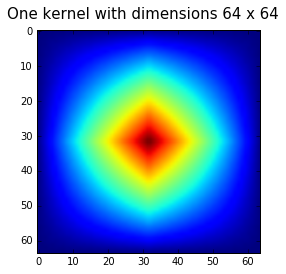

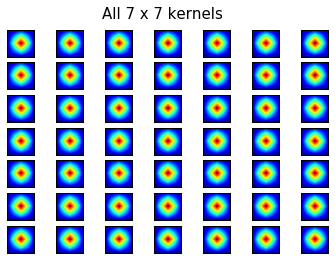

In [5]:
import numpy as np
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import matplotlib.pyplot as plt
%matplotlib inline


# Adjust the following:
######################################################################
kernel_dims = [64,64]
nclasses = 7
######################################################################


def create_bilinear_kernels(num_classes, kernel_dims):
    """Creates a 2D bilinear distribution for initializing the weights for transposed convolution."""
    """Output: NumPy array with dimensions: [kernel_dims[0] x kernel_dims[1] x num_classes x num_classes]"""
    def find_params(size):
        """For odd size: take the mid pixel as the center, for even size: take two adjacent pixels as the center."""
        divisor = np.floor((size + 1) / 2.0)
        if size%2==0:
            center = divisor - 0.5
        else:
            center = divisor - 1
        return divisor,center

    # note the expected shape of kernel_dims variable
    height, width = kernel_dims
    
    # Determine the center and the divisor for height and width
    divisor_height,center_height = find_params(height)
    divisor_width,center_width = find_params(width)
    
    # Create one kernel with ones in the center, and decrease the value further away we move from there:
    grid = np.ogrid[:height, :width]
    filter_coefficients = (1.0 - abs(grid[0] - center_height) / divisor_height) * (1.0 - abs(grid[1] - center_width) / divisor_width)
    # Now put everything into a NumPy array in the required float32 precision (shape: [height x width])
    one_plane = np.array(filter_coefficients, dtype=np.float32)
    # For each input feature map to each output feature map, 
    # we will use transposed convolution with a kernel of [height x width].
    # There are num_classes input feature maps and also num_classes output feature maps.
    # Hence we will first initialize a NumPy array with dimensionality [height x width x num_classes x num_classes]...
    all_planes = np.zeros((height,
                width,
                num_classes,
                num_classes), dtype=np.float32)

    # ... and then copy one_plane to all num_classes x num_classes entries in the last two dimensions.
    for i in range(num_classes):
        for j in range(num_classes):
            all_planes[:, :, i, j] = one_plane
    return all_planes



# Draw the weights for initializing one kernel
bilinear_kernels = create_bilinear_kernels(nclasses, kernel_dims)
plt.imshow(bilinear_kernels[:,:,0,0])
plt.suptitle("One kernel with dimensions %d x %d" %(kernel_dims[0],kernel_dims[1]), fontsize=15)
plt.show() 

# Draw the miniatures of the weights for initializing all kernels
fig, axes = plt.subplots(ncols=nclasses, nrows=nclasses)
fig.suptitle(("All %d x %d kernels" %(nclasses,nclasses)), fontsize=15)
for row in range(nclasses):
    for col in range(nclasses):
        axes[row, col].imshow(bilinear_kernels[:,:,row,col])
        axes[row, col].get_xaxis().set_visible(False)
        axes[row, col].get_yaxis().set_visible(False)
plt.show()

# 5.2 A complete FCN head for Semantic Segmentation with a MobileNet stem

In this section, we combine many learnings from earlier parts of this notebook. So read carefully and check for yourself if you have understood everything.

We will construct a very simple Fully Convolutional Network [(Long et al., 2015)](#source_fcn) head to our MobileNet stem that enables training the overall architecture for a Semantic Segmentation task. Even though this FCN head is very basic – do not expect to win any competitions with it – it will do an adequate job on our Cityscapes dataset and can serve as solid learning material.

Here is the architecture of mentioned FCN head that we will subsequently implement (note that we have omitted the activation and batch normalization layers for all convolution layers):

<img src='images/FCN_head.png'>

* As you can see, we append it to a pruned MobileNet with a spatial output dimensionality of 10 x 15, whereas the depth of the MobileNet output is determined by `1024*d_mul` (making use of the Depth Multiplier parameter, here `d_mul`, that we previously described). **In the code below, `d_mul` is referred to as `depth_multiplier`.**

* The head's first convolution layer is there to replace the average pooling layer of the classification MobileNet topology with a window size of 7x7 (remember your findings from [Exercise A](#exercise_A)). For this layer, we have to choose a kernel size `k`, while we use TensorFlow's `'FULL'` padding policy and a stride of 1 so that our resolution does not change.  The greater the value for `k`, the greater the receptive field of the network, which basically represents the size of an area on the input image that is responsible for the prediction of one output pixel. To keep the computational needs within that layer low, we use the Depth-wise Convolution concept that is prominently present in MobileNets (if you are interested, you can calculate how many operations are required if we used Classical Convolution with a kernel size of `k=7` if you have 1024 input features and 1024 filters – as you may guess, a lot). Correspondingly, we have first have the Separable Convolution layer `conv1_separable`, producing `1024*d_mul` output feature maps, which is followed by a Point-wise Convolution layer, which we will describe in the following bullet point. **In the code below, `k` is referred to as `kernel`.**
* The Point-wise Convolution layer `conv1_pointwise` has a 1x1 kernel and `d` filter maps, so that the output feature map depth is equal to `d`. **In the code below, `d` is referred to as `depth`.**
* In the subsequent layer `conv2_classifier`, we intend to classify each of the 10x15 pixels received from the previous layer into `n` classes. We hence use another 1x1 convolution layer with `n` filters. **In the code below, `n` is referred to as `num_classes`.**
* In principle, the output feature maps from the previous 1x1 convolution layer could already serve for a very coarse-grained Semantic Segmentation task where a region of 32x32 input pixels would be processed to a prediction of a single pixel. Our goal is to output predictions at a (single-)pixel granularity; we will therefore make use of the Transposed Convolution layer `upsampler` with the parameters [from the question you answered earlier](#transposed_question) and initialize the weights with the function we got to know in [Exercise C](#exercise_C). All the previous layers are initialized with the Xavier weight filler.
___

## Exercise D
___

### Question 5.2.1
Now take a look at the following code block. Above layers' parameters can be adjusted in the function `add_fcn_head()`. To put this into the full context of our MobileNet architecture, `mobilenet_fcn()` creates the MobileNet stem we had derived earlier and attaches above FCN head to it. After studying the script below, fill in the number of classes you want to predict, and verify that you achieve a pixel-wise classification accuracy:

In [6]:
def add_fcn_head(net, num_classes, input_shape, is_training, kernel=[7,7], depth=1024):
    """Adds a very simple fully convolutional head to the network specified with net."""
    """num_classes defines the target output depth of the upsampling layer and the last point-wise convolution layer before that."""
    """input_shape shape is needed for determining the target dimensionality after upsampling."""
    """is_training indicates if we have to initialize the weights."""
    """kernel determines the size of the first convolution layer's filter."""
    """depth is the parameter for the number of the point-wise convolution layers' filters in this FCN head."""
    
    # This is the Depth-wise Convolution block:
    # First the Separable Convolution layer with the specified kernel, 
    # taking the output from the MobileNet stem as an input...
    # Input shape: [10 x 15 x (1024*depth_multiplier from MobileNet stem)]
    # Output shape: [10 x 15 x 1024*depth_multiplier from MobileNet stem)]
    conv1_separable = slim.separable_conv2d(net, None, kernel,
        depth_multiplier=1.0,
        stride=[1,1],
        normalizer_fn=slim.batch_norm,
        scope='conv1_separable')
    # ... and the following Point-wise Convolution layer.
    # Input shape: [10 x 15 x (1024*depth_multiplier from MobileNet stem)]
    # Output shape: [10 x 15 x depth]
    conv1_pointwise = slim.conv2d(net, depth, [1, 1], 1, scope='conv1_pointwise')
    
    # Let's use Dropout layer with a common Dropout ratio of 0.5 for regularization.
    # Input shape: [10 x 15 x depth]
    # Output shape: [10 x 15 x depth]
    dropout_keep_prob=0.5
    dropout = slim.dropout(conv1_pointwise, dropout_keep_prob, is_training=is_training, scope='dropout')
    
    # The 1x1 Convolution layer, used as a classifier with num_classes output feature maps.
    # Input shape: [10 x 15 x depth]
    # Output shape: [10 x 15 x num_classes]
    conv2_classifier = slim.conv2d(dropout, num_classes, [1, 1], 1, scope='conv2_classifier')
    
    # The Transposed Convolution Layer, upsampling from 10 x 15 to the original input image resolution of 320 x 480.
    # Input shape: [10 x 15 x num_classes]
    # Output shape: [320 x 480 x num_classes]
    
    # This is a fixed setting which can only upsample by a factor of 32.
    # Let's first assert that this condition is met:
    current_shape = net.get_shape().as_list()
    factor_height = input_shape[1]/current_shape[1]
    factor_width = input_shape[2]/current_shape[2]
    upsampling_factor = 32
    assert(factor_height==factor_width==upsampling_factor)
    
    # upsample_kernel_size = upsampling_factor * 2
    upsample_kernel_size = 64
    
    if is_training:
        # Only initialize the kernel weights with a bilinear distribution if we start from scratch during training.
        filter_coefficients = create_bilinear_kernels(num_classes, [upsample_kernel_size, upsample_kernel_size])
    else:
        # Otherwise, just use zeros because we will reuse the pre-trained weights of a snapshot for inference.
        filter_coefficients = [0]
        
    # upsample_stride = upsampling_factor
    upsample_stride = 32
    
    upsampler = slim.conv2d_transpose(conv2_classifier, num_classes, 
        kernel_size = [upsample_kernel_size, upsample_kernel_size],
        stride=[upsample_stride, upsample_stride],
        scope='upsampler',
        padding='SAME', # Note: With slim.conv2d_transpose, the padding will be calculated automatically.
        weights_initializer=tf.constant_initializer(filter_coefficients),
        trainable=True,
        activation_fn=None) # Softmax will only be applied during training. For inference, we can use argmax.
    return upsampler


def mobilenet_fcn(input_tensor, num_classes, is_training=True, depth_multiplier=1.0, classifier_kernel=[7,7], classifier_depth=1024):
    input_shape  = input_tensor.get_shape().as_list()
    with slim.arg_scope([slim.conv2d, slim.separable_conv2d],
                        weights_initializer=tf.contrib.layers.xavier_initializer(),
                        weights_regularizer=slim.l2_regularizer(1e-6),
                        padding='SAME'):
        base,_ = mobilenet_v1_base(input_tensor, scope='MobilenetV1', final_endpoint='Conv2d_13_pointwise', depth_multiplier=depth_multiplier)
        fcn = add_fcn_head(base, num_classes, input_shape, is_training, kernel=classifier_kernel, depth=classifier_depth)
        return fcn
    
    
height_fcn = 320 # The height of one input image
width_fcn = 480 # The width of one input image

# Fill in the number of classes from your use case
######################################################################
number_classes_fcn = 7
######################################################################


my_image_tensor_fcn = tf.placeholder(tf.float32, shape=(1, height_fcn, width_fcn, 3))     

tf.reset_default_graph()
my_mobilenet_fcn = mobilenet_fcn(input_tensor=my_image_tensor_fcn, num_classes=number_classes_fcn)

input_shape_fcn = my_image_tensor_fcn.get_shape().as_list()
output_shape_fcn = my_mobilenet_fcn.get_shape().as_list()
print('Input dimensions: ' + str(input_shape_fcn))
print('Output dimensions: ' + str(output_shape_fcn))


Input dimensions: [1, 320, 480, 3]
Output dimensions: [1, 320, 480, 7]


___
### Question 5.2.2
What are the two regularization methods that are applied in the code defining the network?  Type your answer in this Markdown cell.


#### Regularization methods include dropout, and L2 regularization (slim.l2_regularizer). 

___
<a id='chapter_dataset'></a>
# 6. Preparing the dataset and importing it to DIGITS
Originally, the Cityscapes dataset [(Cordts et al., 2016)](#source_cityscapes) actually contains images at a resolution of [$1024$ x $2048$] pixels with pixel-wise annotations for 30 classes, but we use a version downsized to [$320$ x $480$] in order to keep your training cycle times low. In the following, we will show you how we cropped and downs-sampled the images.

As mentioned, the dimensions [$1024$ x $2048$] of our dataset are not really suitable for the given time frame within this lab. Additionally, the hood of the vehicle that Cityscapes has been recorded with is present at the bottom of all images. Also "blurry" borders can be seen on top of the images, which is the result of rectifying them according to the camera's lens properties after recording. We hence first cropped a central region from the original image and its corresponding annotation to the dimensions [$768$ x $1152$], and then downsampled it to [$320$ x $480$]. This process is shown with our example frame to give you an impression of the actual proportions we will be operating with:

<img src='images/cropped_cityscapes.png'>

By default, Cityscapes contains 3475 file pairs of camera images with their corresponding pixel-wise annotations (the 1525 test samples are unlabeled), out of which 2975 pairs belong to the training set taken in 18 German cities  (one of them being Cologne) and 500 to the validation set taken in Frankfurt, M&uuml;nster and Lindau. These original sets have been restructured as shown in the following table:

|Original set |New set|Original #samples| New #samples|Comment|
|-----|-----|-----|-----|-----|
|Training set |Training set|2975|900|On average, drew  $900/2875 \approx 30\%$ from all 18 training cities (evenly distributed).|
|Validation set (M&uuml;nster)|Validation set|174|100|Using 100 out of 174 samples from the validation set taken in M&uuml;nster as the new validation set (randomly sampled).|
|Validation set (Lindau)|Test set |59 |59|Using all 59 images from the (fully labeled) validation set taken in Lindau as the new test set. The original Cityscapes test set does not contain labels.|

We have ordered the pre-processed Cityscapes dataset in the following way: It consists of one features folder and one labels/annotations folder for each of the training, validation and test sets, totaling 6 folders.

The features folders contain color images of size [$360$ x $480$ x $3$] with 8-bit RGB values. For example, a pixel  showing the sky in the upper central part of image `train/cologne_000012_000019.png` (the cropped one we see above) has the values `[194 210 210]`.

The annotation folders contain pixel-wise label images of size [$360$ x $480$ x $1$] with 8-bit gray-scale values. The corresponding label for `train/cologne_000012_000019.png` is given the same file name, but logically resides in a different folder: `trainannot/cologne_000012_000019.png`. The pixel in the label image corresponding to the previously mentioned sky pixel is then containing the class index of "Sky": `23`.
___

## 6.1 Class reduction of Cityscapes

Go through the following exercise and study the code block below.

### Exercise E
___
#### Question 6.1.1
First study, then modify the following code snippet to match your use case – pay special attention to the number of classes you want to detect, [as defined in your use case scenario](#scenarios). The output classes are predefined, however, you will have to figure out a mapping from the old classes to the 7 and 2 classes, respectively. Then run the script to crop all images to a resolution of 320 x 480 and perform the class re-mapping. The processed output files will be stored in `/data/Cityscapes_preprocessed`.

In [7]:
import os
import distutils
from distutils import dir_util
from scipy import misc

# Old classes:
# 0: Unlabeled
# 1: Ego vehicle
# 2: Rectification border
# 3: Out of roi
# 4: Static
# 5: Dynamic
# 6: Ground
# 7: Road
# 8: Sidewalk
# 9: Parking
# 10: Rail track
# 11: Building
# 12: Wall
# 13: Fence
# 14: Guard rail
# 15: Bridge
# 16: Tunnel
# 17: Pole
# 18: Polegroup
# 19: Traffic light
# 20: Traffic sign
# 21: Vegetation
# 22: Terrain
# 23: Sky
# 24: Person
# 25: Rider
# 26: Car
# 27: Truck
# 28: Bus
# 29: Caravan
# 30: Trailer
# 31: Train
# 32: Motorcycle
# 33: Bicycle


# New class names for a class number of 7:
# 0: Sky
# 1: Infrastructure
# 2: Road
# 3: Sidewalk
# 4: Vehicles
# 5: VRU (Vulnerable Road Users)
# 6: Void


def reduce_classes(mapping_list, src_folder, dst_folder):
    """Walks iteratively through src_folder and crops all feature and label images to a height of 320 pixels."""
    """Identifies label images if they have only one color channel and applies label conversion based on mapping_list."""
    """Stores new files in dst_folder with the same folder topology as src_folder."""
    for root,dirs,files in os.walk(src_folder):
        print('Started to process all images in %s...' % str(root))
        dst_subfolder = os.path.join(dst_folder,root.split('/')[-1])
        # Check if the current directory is a labels folder, if yes: perform label conversion...
        if str(root).endswith('annot'):
            for f in files:
                if str(f).endswith('.png'):
                    filename_src = os.path.join(root,f)
                    image = misc.imread(filename_src)
                    
                    filename_dst = os.path.join(dst_subfolder,f)
                    if not os.path.exists(dst_subfolder):
                        os.makedirs(dst_subfolder)
                    image_copy = image.copy()
                    for mapping in mapping_list:
                        image[image_copy==mapping.old_id] = mapping.new_id
                    misc.imsave(filename_dst, image)
            print('Stored all processed images in %s.' % str(dst_subfolder))
        # ... if no, copy the current folder to the new directory if there are files present...
        elif len(files) > 0:
            distutils.dir_util.copy_tree(root, dst_subfolder)
            print('Stored all processed images in %s.' % str(dst_subfolder))
        # ... otherwise skip this folder (this will happen for the top folder /Cityscapes).
        else:
            print('No images to process.')
    print('\n\nDone. ')
                

def check_mapping_list(mapping_list, number_classes):
    """This is a sanity check to make sure your mapping_list is aligned with the number of classes from your use case."""
    new_classes = [mapping.new_id for mapping in mapping_list]
    unique_classes = set(new_classes)
    if len(unique_classes) == number_classes:
        print("PASS: Your class mapping configuration is corresponding to the expected number of classes.\n")
        return True
    else:
        print("ERROR: Your class mapping configuration is NOT corresponding to the expected number of classes. Please check mapping_list and/or number_classes")
        return False


class ClassMapping():
    """Simple data structure for the mapping from one original (old) class to one new class."""
    def __init__(self, old_id, new_id, old_name, new_name):
        self.old_id = old_id
        self.new_id = new_id
        self.old_name = old_name
        self.new_name = new_name

# For sanity checking (a checksum), fill in the number of classes from your use case first:
######################################################################
number_classes = 7
######################################################################


# How would you allocate the original classes to the target classes?
# Using the example template provided below, complete mapping_list.
######################################################################
mapping_list=[
    ClassMapping(old_id=0, new_id=6, old_name='Unlabeled', new_name='Void'),
    ClassMapping(old_id=1, new_id=6, old_name='Ego vehicle', new_name='Void'),
    ClassMapping(old_id=2, new_id=1, old_name='Rectification border', new_name='Infrastructure'),
    ClassMapping(old_id=3, new_id=6, old_name='Out of roi', new_name='Void'),
    ClassMapping(old_id=4, new_id=1, old_name='Static', new_name='Infrastructure'),
    ClassMapping(old_id=5, new_id=5, old_name='Dynamic', new_name='VRU'),
    ClassMapping(old_id=6, new_id=6, old_name='Ground', new_name='Void'),
    ClassMapping(old_id=7, new_id=2, old_name='Road', new_name='Road'),
    ClassMapping(old_id=8, new_id=3, old_name='Sidewalk', new_name='Sidewalk'),
    ClassMapping(old_id=9, new_id=4, old_name='Parking', new_name='Vehicles'),
    ClassMapping(old_id=10, new_id=1, old_name='Rail track', new_name='Infrastructure'),
    ClassMapping(old_id=11, new_id=1, old_name='Building', new_name='Infrastructure'),
    ClassMapping(old_id=12, new_id=1, old_name='Wall', new_name='Infrastructure'),
    ClassMapping(old_id=13, new_id=1, old_name='Fence', new_name='Infrastructure'),
    ClassMapping(old_id=14, new_id=1, old_name='Guard rail', new_name='Infrastructure'),
    ClassMapping(old_id=15, new_id=1, old_name='Bridge', new_name='Infrastructure'),
    ClassMapping(old_id=16, new_id=1, old_name='Tunnel', new_name='Infrastructure'),
    ClassMapping(old_id=17, new_id=1, old_name='Pole', new_name='Infrastructure'),
    ClassMapping(old_id=18, new_id=1, old_name='Polegroup', new_name='Infrastructure'),
    ClassMapping(old_id=19, new_id=1, old_name='Traffic light', new_name='Infrastructure'),
    ClassMapping(old_id=20, new_id=1, old_name='Traffic sign', new_name='Infrastructure'),
    ClassMapping(old_id=21, new_id=6, old_name='Vegetation', new_name='Void'),
    ClassMapping(old_id=22, new_id=1, old_name='Terrain', new_name='Infrastructure'),
    ClassMapping(old_id=23, new_id=0, old_name='Sky', new_name='Sky'),
    ClassMapping(old_id=24, new_id=5, old_name='Person', new_name='VRU'),
    ClassMapping(old_id=25, new_id=5, old_name='Rider', new_name='VRU'),
    ClassMapping(old_id=26, new_id=4, old_name='Car', new_name='Vehicle'),
    ClassMapping(old_id=27, new_id=4, old_name='Truck', new_name='Vehicle'),
    ClassMapping(old_id=28, new_id=4, old_name='Bus', new_name='Vehicle'),
    ClassMapping(old_id=29, new_id=4, old_name='Caravan', new_name='Vehicle'),
    ClassMapping(old_id=30, new_id=4, old_name='Trailer', new_name='Vehicle'),
    ClassMapping(old_id=31, new_id=4, old_name='Train', new_name='Vehicle'),
    ClassMapping(old_id=32, new_id=5, old_name='Motorcycle', new_name='VRU'),
    ClassMapping(old_id=33, new_id=5, old_name='Bicycle', new_name='VRU'),
]
######################################################################



# Do not modify these two folders.
src_folder = '/data/Cityscapes'
dst_folder = '/data/Cityscapes_preprocessed'

# Only run reduce_classes if the sanity check is successful.
if(check_mapping_list(mapping_list, number_classes)):
    reduce_classes(mapping_list, src_folder, dst_folder)

PASS: Your class mapping configuration is corresponding to the expected number of classes.

Started to process all images in /data/Cityscapes...
No images to process.
Started to process all images in /data/Cityscapes/test...
Stored all processed images in /data/Cityscapes_preprocessed/test.
Started to process all images in /data/Cityscapes/testannot...
Stored all processed images in /data/Cityscapes_preprocessed/testannot.
Started to process all images in /data/Cityscapes/val...
Stored all processed images in /data/Cityscapes_preprocessed/val.
Started to process all images in /data/Cityscapes/trainannot...
Stored all processed images in /data/Cityscapes_preprocessed/trainannot.
Started to process all images in /data/Cityscapes/valannot...
Stored all processed images in /data/Cityscapes_preprocessed/valannot.
Started to process all images in /data/Cityscapes/train...
Stored all processed images in /data/Cityscapes_preprocessed/train.


Done. 


## 6.2 Importing the modified Cityscapes dataset into DIGITS
Now that we have the Cityscapes dataset in the resolution we require and have reduced the pixel-wise annotations to the number of classes specified in the scenario from the Introduction, we can go ahead and import everything into DIGITS. 

### <a href="/digits/" target=\"_blank\">Open DIGITS</a> in a separate window first.
In case you are new to DIGITS, take a brief look at [the overview given on the NVIDIA website](https://developer.nvidia.com/digits). Independent of the back-end framework you use DIGITS with (we will use TensorFlow), you may create datasets that can be interpreted by any of them and visualize the learning process as well as the inference results on selected input images in the same way.

At first, click on the leftmost `Datasets` tab, then open the `New Datasets` drop-down menu to the right and select `Segmentation`.

<img src='images/digits/digits_dataset_dropdown.png'>

DIGITS is specifically designed for multiple users using the same hardware. Even though you will be the only user on the server instance that you run this Jupyter notebook on, create your personal user alias:

<img src='images/digits/digits_username.png' width="800">

Now specify the paths to both the input images and the labels of your training and validation set by copying all settings shown in the screen shot below (do not forget to tick `Separate validation images`).

In case you do not want to type the paths, here a table you can copy-paste from:

|Field |Path|
|-----|-----|
|`Feature image folder` |`/data/Cityscapes_preprocessed/train`|
|`Label image folder` |`/data/Cityscapes_preprocessed/trainannot`|
|`Validation feature image folder` |`/data/Cityscapes_preprocessed/val`|
|`Validation label image folder` |`/data/Cityscapes_preprocessed/valannot`|

For `Class Labels`, choose the correct file corresponding to the number of classes from your use case:

|Number of classes |Path for `Class Labels`|
|-----|-----|
|2 |`/data/label_lists/cityscapes_labels_2classes.txt`|
|7 |`/data/label_lists/cityscapes_labels_7classes.txt`|


<img src='images/digits/digits_dataset_settings1.png' width="800">

Now give your dataset a meaningful name (for example, `Cityscapes_2classes` or `Cityscapes_7classes`) and click `Create`:

<img src='images/digits/digits_dataset_settings2.png' width="800">

It will take a short while until your dataset creation has finished. Once that happened, sanity-check the number of elements in your `train_db` and your `val_db`, together with their dimensionality. The result should look like this (with different path locations in the `/jobs` folder):

<img src='images/digits/digits_dataset_sanity_check.png' width="640">

Now we are good to go and can proceed to the final section of this lab: The training stage.

<a id='chapter_fcn_training'></a>
# 7. Putting everything together: Training in DIGITS


## 7.1 Exploring the parameter space for a suitable FCN architecture
Before we start training, let's explore the available design space in terms of the four parameters we intend to modify:

`DEPTH_MULTIPLIER`, which is the depth multiplier for your MobileNet stem. <br>
`CLASSIFIER_KERNEL`, which is the kernel size for the Separable Convolution layer of the FCN head. <br>
`CLASSIFIER_DEPTH`, which is the depth of the (first) Point-wise Convolution layer of the FCN head. <br>
`NUMBER_CLASSES`, which is is the class number from your use case. <br>


While `NUMBER_CLASSES` is predefined in [the use case scenario](#scenarios), we will have to modify the other 3 parameters to meet the most restrictive requirement: The available budget of Giga operations **per second**.

**Per second** is an important indication here: In the Theory section, we learned how to calculate the number of operations for a single CNN forward pass at a given input size. But now we need to perform multiple predictions for potentially multiple cameras with number `n_cameras`, and this process is expected to be repeated at the frequency `fps_per_camera`. That means we have a total throughput of `images_per_second = n_cameras * fps_per_camera` images per second.

If we do know the computational requirements for processing one image in Mega ($10^6$) operations with `megaops_per_image`, we can thus calculate the total requirements in Giga ($10^9$) operations per second:


`gigaops_per_second = images_per_second * megaops_per_image / 1000`

We now know the target output that should stay within our budget constraints, and also know which 3 parameters we can tune to reach that: In a first step, we would probably first choose a **`DEPTH_MULTIPLIER`** for defining the MobileNet stem: This will be the hungriest part of our Fully Convolutional Network.

From the architecture of the FCN head, we see that the depth of the two final layers' depends on `NUMBER_CLASSES`, which we can directly fix according to the use case. The parameters **`CLASSIFIER_KERNEL`** and **`CLASSIFIER_DEPTH`** thus show the only potential for tuning the computational needs of the FCN head. Before we proceed to the final code blocks within this notebook:
### Take a look at this spreadsheet on Google Drive: https://docs.google.com/spreadsheets/d/1cxCgM6XNZkF4Zj1jowypBk-LMau9MC2I2w0fHVjcWIM/edit?usp=sharing.

On top, you see a table listing the number of Mega operations needed for a forward pass in the MobileNet stem, with different **`DEPTH_MULTIPLIER`** settings at an input size of [320 x 480 x 3].

The lower two tables are correspondingly indicating the number of Mega operations for the FCN head, which is 
upsampling from [10 x 15 x (1024*`DEPTH_MULTIPLIER`)] to [320 x 480 x `NUMBER_CLASSES`] with values for `CLASSIFIER_KERNEL` and for `CLASSIFIER_DEPTH`.

## Exercise F

### Question 7.1.1
Take pen and paper and estimate which parameter settings for  **`DEPTH_MULTIPLIER`**, **`CLASSIFIER_KERNEL`** and **`CLASSIFIER_DEPTH`** are candidates for meeting the budget requirements of your use case. Hint: The spreadsheet indicates numbers in Mega ($10^6$) operations per single prediction while your budget is given in Giga ($10^9$) operations per second, and you will have to make use of the formula for calculating `gigaops_per_second`. **It is recommended to use `DEPTH_MULTIPLIER` $\in \{0.25, 0.50, 0.75, 1.0\}$**.

#### TODO

### Question 7.1.2

Now verify your assumptions with below code block: From the previous question, you should know beforehand which `DEPTH_MULTIPLIER` is generally possible. Now you can play around with the other parameters, and also specify the number of cameras and the target frame rate from your use case. To get a better understanding about how the computations are distributed among the layers, we gave you a helper function printing out layer-wise statistics. If you have frozen your parameters, execute the code block and write down your computational needs in Giga operations:

In [8]:
from calculate_ops import get_megaops

# Modify these values:
######################################################################
DEPTH_MULTIPLIER= 0.25
CLASSIFIER_KERNEL= [7,7]
CLASSIFIER_DEPTH=1024
NUMBER_CLASSES= 7
######################################################################


my_image_tensor_fcn = tf.placeholder(tf.float32, shape=(1, 320, 480, 3))
tf.reset_default_graph()
my_mobilenet_fcn = mobilenet_fcn(
            input_tensor=my_image_tensor_fcn, 
            num_classes=NUMBER_CLASSES, 
            depth_multiplier=DEPTH_MULTIPLIER, 
            classifier_kernel=CLASSIFIER_KERNEL, 
            classifier_depth=CLASSIFIER_DEPTH
        )

output_shape_fcn = my_mobilenet_fcn.get_shape().as_list()
print('Output dimensions: ' + str(output_shape_fcn))

megaops_per_image = get_megaops(my_mobilenet_fcn, verbose=True)
# Modify these values according to your use case:
######################################################################
n_cameras = 4
fps_per_camera = 30
######################################################################

images_per_second = n_cameras * fps_per_camera

gigaops_per_second = images_per_second * megaops_per_image / 1000

print('%.1f Giga operations for %d images per second' % (gigaops_per_second, images_per_second))

Output dimensions: [1, 320, 480, 7]
Layer name                                     MFLOPS      %
-------------------------------------------  --------  -----
MobilenetV1/Conv2d_0/convolution                 16.6    4.2
MobilenetV1/Conv2d_1_depthwise/depthwise          5.5    1.4
MobilenetV1/Conv2d_1_pointwise/convolution        9.8    2.5
MobilenetV1/Conv2d_2_depthwise/depthwise          2.8    0.7
MobilenetV1/Conv2d_2_pointwise/convolution        9.8    2.5
MobilenetV1/Conv2d_3_depthwise/depthwise          5.5    1.4
MobilenetV1/Conv2d_3_pointwise/convolution       19.7    5.0
MobilenetV1/Conv2d_4_depthwise/depthwise          1.4    0.3
MobilenetV1/Conv2d_4_pointwise/convolution        9.8    2.5
MobilenetV1/Conv2d_5_depthwise/depthwise          2.8    0.7
MobilenetV1/Conv2d_5_pointwise/convolution       19.7    5.0
MobilenetV1/Conv2d_6_depthwise/depthwise          0.7    0.2
MobilenetV1/Conv2d_6_pointwise/convolution        9.8    2.5
MobilenetV1/Conv2d_7_depthwise/depthwise         

## 7.2 Creating a MobileNet-FCN model in DIGITS

Now we can finally make use of the dataset we previously created in DIGITS, and train our MobileNet-FCN architecture!

### <a href="/digits/" target=\"_blank\">Open DIGITS</a> in a separate window again.

Similar to the dataset creation process, click on the `Models` tab, then open the `New Model` drop-down menu to the right and select `Segmentation`.

<img src='images/digits/digits_model_dropdown.png'>

As shown below, select your dataset in the top left box, and copy the following settings in the `Solver Settings` box. We will use the `Adam` solver [(Kingma and Ba, 2014)](#source_adam) with a `Fixed` (change to this mode from `Step` in the corresponding drop-down menu, which appears after checking the `Show advanced learning rate options` box) learning rate of `0.001`, the recommended setting from the classification MobileNet version we derived "our" MobileNet-FCN. In the `Data Transformations` box, select `Pixel`: This will subtract the same RGB value from all pixels for all input images. For now, we do not apply any data augmentations but you are invited to experiment with these settings outside of this lab:

<img src='images/digits/digits_model_settings1.png' width="800">

Before we go further, prepare your clipboard with the following code; first fill in the values for `DEPTH_MULTIPLIER`, ` CLASSIFIER_KERNEL`, `CLASSIFIER_DEPTH`, `NUMBER_CLASSES` from the earlier code snippet that you feel comfortable with, and then **select ALL lines from code block below and copy them into your clipboard**:

In [24]:
from model import Tower
from utils import model_property
import tensorflow as tf
import tensorflow.contrib.slim as slim
import utils as digits
import mobilenet_v1

import sys
sys.path.append('/notebooks')

from mobilenet_fcn_from_notebook import add_fcn_head, iou_score

#Copy the values from above into the following field, then copy all contents of this cell into your clipboard.
######################################################################
DEPTH_MULTIPLIER= 0.25
CLASSIFIER_KERNEL= [7,7]
CLASSIFIER_DEPTH=1024
NUMBER_CLASSES= 7
######################################################################

def create_fcn_model(x, num_classes, is_training, depth_multiplier, kernel_classifier, depth_classifier):
    input_shape  = x.get_shape().as_list()
    net,_ = mobilenet_v1.mobilenet_v1_base(x, scope='MobilenetV1', final_endpoint='Conv2d_13_pointwise', depth_multiplier=depth_multiplier)
    net = add_fcn_head(net, num_classes, input_shape, is_training, kernel=kernel_classifier, depth=depth_classifier)
    return net

class UserModel(Tower):

    @model_property
    def inference(self):
        # The expected number of classes is defined first (we do not read this from the dataset):
        self.nclasses = NUMBER_CLASSES
        # The input batch has to be in the shape [batch_size x height x width x channels] ("NHCW"):
        x = tf.reshape(self.x, shape=[-1, self.input_shape[0], self.input_shape[1], self.input_shape[2]])
        # Use the following settings for layers of types slim.conv2d and slim.separable_conv2d
        with slim.arg_scope([slim.conv2d, slim.separable_conv2d],
                            weights_initializer=tf.contrib.layers.xavier_initializer(),
                            weights_regularizer=slim.l2_regularizer(1e-6),
                            padding='SAME'):
            fcn = create_fcn_model(x, self.nclasses, self.is_training, DEPTH_MULTIPLIER, CLASSIFIER_KERNEL, CLASSIFIER_DEPTH)
            if self.is_inference:
                # If we use the network's prediction for visualization in DIGITS, let's convert the output from NHCW to NCHW.
                fcn = digits.nhwc_to_nchw(fcn)
        return fcn

    @model_property
    def loss(self):
        predictions = self.inference # Load the inference network from above
        labels = tf.to_int64(self.y) # Make sure that the labels are integers
        # Reshape the predictions from [batch_size x 320 x 480 x 7] to a matrix of [(batch_size*320*480) x 7]:
        predictions_reshaped = tf.reshape( predictions, [-1, self.nclasses] )
        # Reshape the labels from [batch_size x 320 x 480] to a a vector with size [(batch_size*320*480)]:
        labels_reshaped = tf.reshape( labels, [-1] )
        # Let the reshaped predictions run through a Softmax layer, and then calculate the cross-entropy:
        loss = digits.classification_loss(pred=predictions_reshaped, y=labels_reshaped)
        # Calculate the Intersection over Union score. Ignore the last class ID and make it visible during training.
        iou = iou_score(predictions_reshaped,labels_reshaped,skip_classes=[NUMBER_CLASSES-1])
        self.summaries.append(tf.summary.scalar(iou.op.name, iou))
        # Calculate the pixel-wise accuracy and make it visible during training.
        accuracy = digits.classification_accuracy(pred=predictions_reshaped, y=labels_reshaped)
        self.summaries.append(tf.summary.scalar(accuracy.op.name, accuracy))
        return loss

ImportError: No module named model


Now scroll down, click on `Custom Network`, and then on `TensorFlow`. **Then paste the previously copied contents from your clipboard into the text box as shown below.**

**If you are using Google Chrome (which is highly recommended), sanity-check if DIGITS can properly interpret your TensorFlow-based DNN by clicking on `Visualize Network`.**


If you chose a MobileNet base architecture with a `DEPTH_MULTIPLIER` $\in \{0.25, 0.5, 0.75, 1.0\}$, you can use the weights of a pre-trained classification for initialization; to do that, fill in the corresponding path in `Pretrained Model(s)`, as also shown in the image:

|`DEPTH_MULTIPLIER` |Path in `Pretrained model(s)`|
|-----|-----|
|0.25 |`/data/mobilenet_snapshots/mobilenet_v1_0.25.ckpt`|
|0.50 |`/data/mobilenet_snapshots/mobilenet_v1_0.50.ckpt`|
|0.75 |`/data/mobilenet_snapshots/mobilenet_v1_0.75.ckpt`|
|1.0 |`/data/mobilenet_snapshots/mobilenet_v1_1.0.ckpt`|


<img src='images/digits/digits_model_settings2.png' width="800">

Per epoch, we will perform a forward pass for 1000 images (training + validation set combined), and perform a backward pass for the 900 training images. To save time, you could use several GPUs for distributed training. Let's first check how many GPUs we have at our exposure by running the following snippet (we could also look at `nvidia-smi`):

In [28]:
from tensorflow.python.client import device_lib
local_devices = device_lib.list_local_devices()
available_gpus =  sum(1 if x.device_type == 'GPU' else 0 for x in local_devices)

print('Number of GPUs available for training: %d' % available_gpus)

Number of GPUs available for training: 1


With the following setting, you can distribute the training workload over your available GPUs: 
<img src='images/digits/digits_use_gpus.png' width="480">

We are finally there! Give your model a meaningful name and click on `Create` to start the training process. For 15 epochs running on a single GPU, this can easily take around 10 minutes (or even more):

<img src='images/digits/digits_model_settings3.png' width="800">

___
### Question 7.2.1
How is accuracy (in training or validation) defined (as shown in your tensorflow board)? Why is accuracy of your net on this dataset much higher than the IoU?  Type your answers within this Markdown cell.

#### TODO

___
# 7.3 Performance evaluation

If you feel comfortable with your training results, the time for our final assessment has come: Let's visualize the trained MobileNet-FCN's inference on the Cityscapes test set in a video sequence and let's also find the Intersection over Union metric during that run. 

To do so, you will need to provide the job ID of your DIGITS training task. This is shown in the top left box of the model menu:
<img src='images/digits/digits_job_dir.png' width="320">
Copy the job ID into your clipboard and paste it into the code block below. We gave you an example of the format below (to prevent that you confuse it with your own, the prefix dates our training period to the year 1900).

In addition to the job ID, you can select the most promising snapshot epoch – typically the one scoring best for the validation score – and also fill that number into the code snippet below. To make sure that the target snapshot is really present (you could have specified earlier that you do not want to take a snapshot after every epoch), check the drop-down menu in the model menu, directly under your graphs:

<img src='images/digits/digits_select_epoch.png' width="480">

At last, execute the cell. Look at the inference results, and write down the IoU score of your model.

In [9]:
from run_inference_test import run_inference, get_labeled_pairs

%matplotlib inline
%pylab inline

# Fill in the training job ID, together with the snapshot epoch that you would like to have assessed:
######################################################################
JOB_ID='20190202-230613-2391'
SNAPSHOT_EPOCH = 15
######################################################################


# Here we parse the test image folder and associate the correct label with each feature image.
base_path = '/data/Cityscapes_preprocessed/'
image_folder = base_path + 'test'
label_folder = base_path + 'testannot'
filename_pairs = get_labeled_pairs(image_folder,label_folder)

color_map = [
    (70, 130, 180), # 0: Sky - light blue
    (255, 255, 0), # 1: Infrastructure - yellow
    (0, 255, 0), # 2: Road - green
    (244, 35, 232), # 3: Sidewalk - purple
    (0, 0, 255), # 4: Vehicles - dark blue
    (255, 0, 0), # 5: VRU (Vulnerable Road Users) - red
    (0, 0, 0) # 6: Void - transparent
]

job_path = '/jobs/' + JOB_ID
run_inference(job_path, SNAPSHOT_EPOCH, filename_pairs, color_map)


SUCCESS! All images have been evaluated. You can submit your score.
IoU score for 59/59 images: 27.6


___
### Question 7.3.1
According to latest research, what change in the architecture of the stem of your network could provide an additional boost in	 IoU? Type your answers within this Markdown cell. Hint: recall our discussion of latest papers in segmentation in class and think about an architecture that would feed both details and context for details into the FCN head.

#### TODO

___
# Sources

<a id='source_fcn'></a>
Long, J., Shelhamer, E., & Darrell, T. (2015). Fully convolutional networks for semantic
segmentation. In Proceedings of the IEEE Conference on Computer Vision and Pattern
Recognition (pp. 3431-3440).

<a id='source_cityscapes'></a>
Cordts, M., Omran, M., Ramos, S., Rehfeld, T., Enzweiler, M., Benenson, R., ... & Schiele, B. (2016). The Cityscapes dataset for semantic urban scene understanding. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 3213-3223).

<a id='source_mobilenets'></a>
Howard, A. G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., ... & Adam, H. (2017). Mobilenets: Efficient convolutional neural networks for mobile vision applications. arXiv preprint arXiv:1704.04861.

<a id='source_imagenet'></a>
Deng, J., Dong, W., Socher, R., Li, L. J., Li, K., & Fei-Fei, L. (2009). Imagenet: A large-scale hierarchical image database. In Computer Vision and Pattern Recognition, 2009. CVPR 2009. IEEE Conference on (pp. 248-255). IEEE.

<a id='source_alexnet'></a>
Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep
convolutional neural networks. In Advances in neural information processing systems (pp.
1097-1105).

<a id='source_googlenet'></a>
Szegedy, C., Liu, W., Jia, Y., Sermanet, P., Reed, S., Anguelov, D., ... & Rabinovich, A.
(2015). Going deeper with convolutions. In Proceedings of the IEEE Conference on Computer
Vision and Pattern Recognition (pp. 1-9).

<a id='source_vgg'></a>
Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

<a id='source_unet'></a>
Ronneberger, O., Fischer, P., & Brox, T. (2015). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical Image Computing and Computer-Assisted Intervention (pp. 234-241). Springer, Cham.

<a id='source_iou'></a>
Everingham, M., Van Gool, L., Williams, C. K., Winn, J., & Zisserman, A. (2010). The pascal visual object classes (VOC) challenge. International journal of computer vision, 88(2), 303-338.

<a id='source_bilinear'></a>
Prashanth, H. S., Shashidhara, H. L., & KN, B. M. (2009). Image scaling comparison using universal image quality index. In Advances in Computing, Control, & Telecommunication Technologies, 2009. ACT'09. International Conference on (pp. 859-863). IEEE.

<a id='source_depthwise'></a>
Chollet, F. (2016). Xception: Deep Learning with Depthwise Separable Convolutions. arXiv preprint arXiv:1610.02357.

<a id='source_resnet'></a> 
He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition.
In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (pp. 770-
778).

<a id='source_adam'></a>
Kingma, D., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint
arXiv:1412.6980.